<a href="https://colab.research.google.com/github/shengyao1998/fcc-mlpp-project5-neural-network-sms-text-classifier/blob/main/fcc_mlpp_project5_neural_network_sms_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.


This Challange was completed by referring tutorial from tensorflow:
https://www.tensorflow.org/text/tutorials/text_classification_rnn
https://blog.paperspace.com/nlp-spam-detection-application-with-scikitlearn-xgboost/

## 1st Step: Import all Libraries and Data

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re


print(tf.__version__)

2.17.0-dev20240219


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-02-20 06:31:43--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.4’

train-data.tsv.4    100%[===================>] 349.84K  --.-KB/s    in 0.005s  

2024-02-20 06:31:44 (75.0 MB/s) - ‘train-data.tsv.4’ saved [358233/358233]

--2024-02-20 06:31:44--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.4’

valid-data.tsv.4    100%[========

In [ ]:
# Create Training and Testing Datafram, drop header and invalid data
train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()

test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


## 2nd Step: Data Preprocessing

In [ ]:
# Define a Function to remove all punctuation/stopwords
def text_preprocess(message):
    # Remove punctuations
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again
    nopunc = "".join(nopunc)
    nopunc = nopunc.lower()

    # Remove any stopwords and non-alphabetic characters
    nostop = [
        word
        for word in nopunc.split()
        if word.lower() not in stopwords.words("english") and word.isalpha()
    ]

    return nostop

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
# Remove punctuations/stopwords from all messages in both dataframe
train_df["msg"] = train_df["msg"].apply(text_preprocess)
test_df["msg"] = train_df["msg"].apply(text_preprocess)

# Convert messages (as lists of string tokens) to strings
train_df["msg"] = train_df["msg"].agg(lambda x: " ".join(map(str, x)))
test_df["msg"] = test_df["msg"].agg(lambda x: " ".join(map(str, x)))

In [ ]:
# Factorize the Data
# Meaning replaces its values with their corresponding factorized values.
# Factorization is a process of mapping categorical values to numerical values.
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

# Crreate Training Dataset using type and msg values
train_labels = tf.convert_to_tensor(train_df["type"].values)
train_ds = tf.data.Dataset.from_tensor_slices((train_df["msg"].values, train_labels))

test_labels = tf.convert_to_tensor(test_df["type"].values)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["msg"].values, test_labels))

In [ ]:
# Print and check the dataset
for example, label in train_ds.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'hospital da return home evening'
label:  0
text:  b'much textin bout'
label:  0
text:  b'probably wont eat today think im gonna pop weekend u miss'
label:  0
text:  b'give flying monkeys wot think certainly mind friend mine'
label:  0
text:  b'seeing'
label:  0


In [ ]:
# Sets the buffer size for shuffling the training dataset.
# The buffer size determines the number of elements from which the
# shuffle() method randomly samples when shuffling the dataset.
BUFFER_SIZE = 100

# This sets the batch size for both the training and testing datasets.
# The batch size determines the number of samples that will be fed into
# the model at once during training or testing.
BATCH_SIZE = 32

# This line shuffles the training dataset (train_ds) using the specified
# buffer size, batches the shuffled data into batches of the specified
# batch size, and prefetches batches using the tf.data.AUTOTUNE parameter,
# which allows TensorFlow to automatically tune the prefetching buffer sizes.
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Print and check the dataset
for example, label in train_ds.take(5):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'sorry ill call later' b'yesterday going home'
 b'hi finally completed course']

labels:  [0 0 0]
texts:  [b'g wants know fuck'
 b'shit really shocking scary cant imagine second def night u think somewhere could crash night save taxi'
 b'looks like found something smoke great job']

labels:  [0 0 0]
texts:  [b'bank say money' b'dnt wnt tlk wid u' b'cant make tonight']

labels:  [0 0 0]
texts:  [b'back good journey let know need receipts shall tell like pendent'
 b'call tells u call claim prize u enter ur mobile personal details prompts careful'
 b'yet id like keep touch easiest way barcelona way ru house']

labels:  [0 1 0]
texts:  [b'u free sat rite u wan watch infernal affairs wif n darren n mayb xy'
 b'going sao mu today done' b'cool want go kappa meet outside mu']

labels:  [0 0 0]


## 3rd Step: Text Vectorization

In [ ]:
# The code you provided sets up a TextVectorization layer in TensorFlow,
# which is commonly used for preprocessing text data before feeding it
# into a neural network model. Let's break down what each part of the code does:
features_num = 1000
features_len = 500

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=features_num,
    output_mode='int',
    output_sequence_length=features_len)

vectorize_layer.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'u', 'call', 'im', 'ur', 'get', 'dont', 'ill', 'know',
       'free', 'ltgt', 'good', 'go', 'want', 'ok', 'love', 'got', 'like',
       'text'], dtype='<U15')

In [ ]:
encoded_example = vectorize_layer(example)[:3].numpy()
encoded_example

array([[  2,  10, 452, ...,   0,   0,   0],
       [ 37,   1, 777, ...,   0,   0,   0],
       [221,  14,  13, ...,   0,   0,   0]])

## 4th Step: Build and Train

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),
                              output_dim=64,
                              # Use masking to handle the variable sequence lengths
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8725 - loss: 0.6869 - val_accuracy: 0.8604 - val_loss: 0.6795
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8713 - loss: 0.6467 - val_accuracy: 0.8773 - val_loss: 0.6094
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8698 - loss: 0.5566 - val_accuracy: 0.8604 - val_loss: 0.6218
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.8675 - loss: 0.4921 - val_accuracy: 0.8773 - val_loss: 0.5561
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8689 - loss: 0.4470 - val_accuracy: 0.8604 - val_loss: 0.5791
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8661 - loss: 0.3821 - val_accuracy: 0.8773 - val_loss: 0.5192
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8704 - loss: 0.3154 - val_accuracy: 0.8604 - val_loss: 0.5532
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8826 - loss: 0.2423 - val_accuracy: 0.8773 - val_los

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.8712 - loss: 0.5208
Test Loss: 0.5245350003242493
Test Accuracy: 0.8656609058380127


(0.0, 0.7091906744986772)

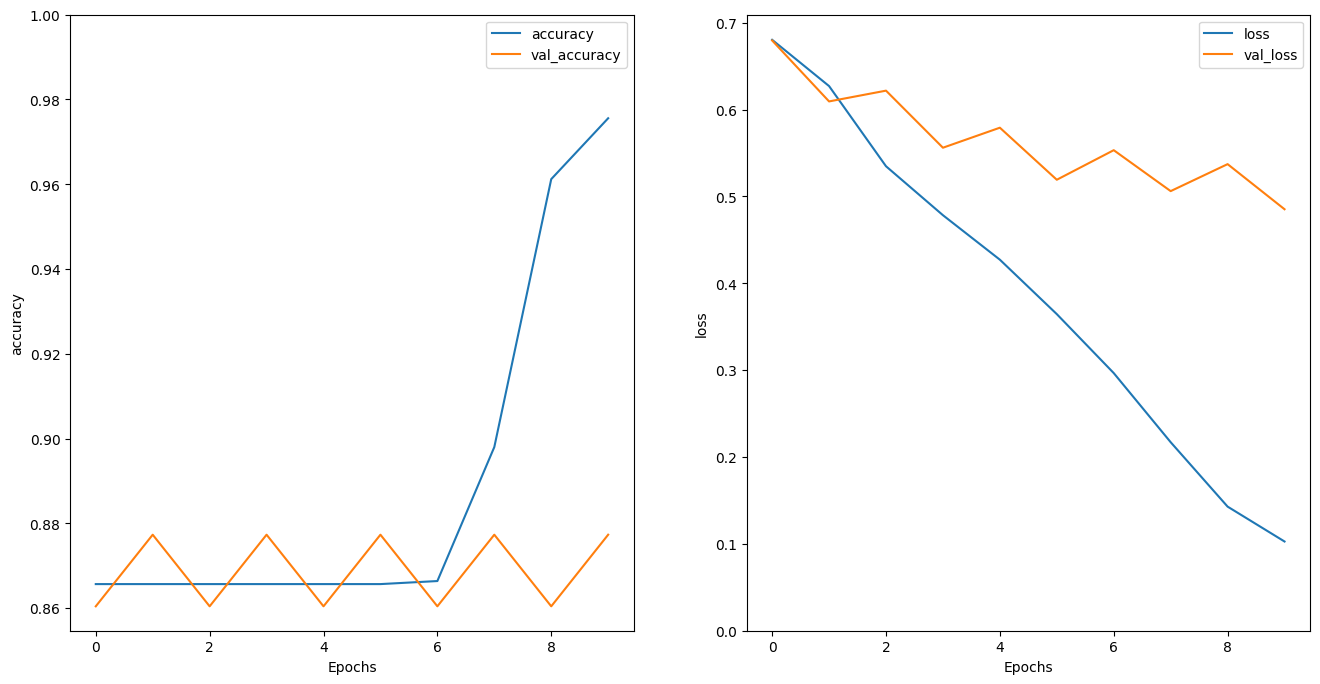

In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6803111433982849, 0.6270459890365601, 0.534740149974823, 0.478385329246521, 0.4271656274795532, 0.3644995391368866, 0.2966216802597046, 0.217037633061409, 0.14288124442100525, 0.10272052139043808]
[0.6795445680618286, 0.6093700528144836, 0.6217746734619141, 0.5560722947120667, 0.5791243314743042, 0.5191906094551086, 0.5532318353652954, 0.5061087608337402, 0.537174642086029, 0.48524239659309387]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8663793206214905, 0.897988498210907, 0.9612069129943848, 0.9755747318267822]
[0.8604166507720947, 0.8773148059844971, 0.8604166507720947, 0.8773148059844971, 0.8604166507720947, 0.8773148059844971, 0.8604166507720947, 0.8773148059844971, 0.8604166507720947, 0.8773148059844971]


## 5th Step: Predict

In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
sample_text_tensor = tf.convert_to_tensor([sample_text])
predictions = model.predict(np.array([sample_text_tensor]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-3.6440432]]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    processed_text = tf.convert_to_tensor([pred_text])
    ps = model.predict([processed_text])
    print(ps)
    p = ps[0][0]

    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
[[-3.9056945]]
[-3.9056945, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[-3.9056945]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[0.5072243]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[[-6.39346]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[1.6239918]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[[2.010165]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[-7.7300944]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[-6.258023]]
You passed the challenge. Great job!
